#### Part 1.

A quanto option, unlike a normal European option that pays the final payoff in the denominated currency of the underlying stock or asset,
it pays the final payoff in another currency at a pre-determined exchange rate.
For example, a stock $S_a$ is listed on Singapore Exchange (SGX) and denominatd in SGD.
A quanto call option allows the holder to receive the payoff $\max(S_a-K, 0)$ in another currency (called the quanto currency), e.g., JPY,  at a pre-fixed exchange rate $F_0 = 100$.
The payoff of the quanto call option in the stock's denominatd currency is thus
$F_0 \times \max(S_a(T)-K, 0) \times S_b(T)$ where $S_b$ is the value of one quanto currency in the unit of the stock's denominated currency.

Assuming the stock and the quanto-denominated currency pair both follow geometric Brownian motion:
\begin{align}
& dS_a(t) / S_a(t) = (r_d - r_a) dt + \sigma_a dW_a \\
& dS_b(t) / S_b(t) = (r_d - r_b) dt + \sigma_b dW_b \\
& dW_a dW_b = \rho dt
\end{align}

where $r_d$ is the risk free interest rate of the stock's denominated currency,
$r_a$ is the continuous yield of the stock,
and $r_b$ is the interest rate of the quanto currency,
and $\rho \in [-1, 1]$ is the correlation between the stock price and the foreign exchange rate.

The closed form solution for a quanto European call option is:
\begin{align}
S_b(0) F e^{-r_bT}\left( S_a(0) e^{(r_d - r_a + \rho \sigma_a \sigma_b)T} N(d_+) - K N(d_-)  \right).
\end{align}
where
\begin{align*}
d_{\pm} = \frac{\ln \frac{S_a(0)}{K} + (r_d - r_a + \rho \sigma_a \sigma_b \pm \frac{1}{2}\sigma_a^2)T}{\sigma_a \sqrt{T}}
\end{align*}

We implement a function to compute the theoretical price of a quanto European call option, which would be used to compare the solution of our numerical pricer.

In [537]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


def quantoCallAnalytic(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0):
    # Compute d+ and d-
    dplus = (math.log(s_a0 / K) + (rd - ra + (rho * sigmaA * sigmaB) + 0.5 * sigmaA**2)*T) / (sigmaA * math.sqrt(T))
    dminus = (math.log(s_a0 / K) + (rd - ra + (rho * sigmaA * sigmaB) - 0.5 * sigmaA**2)*T) / (sigmaA * math.sqrt(T))

    # Compute cdf N(d+) and N(d-)
    Ndplus = norm.cdf(dplus)
    Ndminus = norm.cdf(dminus)

    # Compute analytical price
    expterm = ( rd - ra + rho * sigmaA * sigmaB ) * T # the exponential term
    V = s_b0 * F0 * math.exp(-rb * T) * ( s_a0 * math.exp(expterm) * Ndplus - K * Ndminus )

    return V 
    

Testing the theoretical pricer:

In [540]:
s_a0, s_b0 = 100, 1/80
T, K, F0 = 1,102,100,
rd, ra, rb = 0.02, 0.05, 0.01
sigmaA, sigmaB, rho=0.2, 0.15, 0.4

res = quantoCallAnalytic(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0)

print(f"Quanto European Call Option price: {res:0.4f}")

Quanto European Call Option price: 7.7023


#### Part 2.

Next, we implement a Monte Carlo pricer to price the quanto call option in the stock's denominated currency

#### Formulation of the MC simulation
The price of quanto European Call Option, evaluated at time t=0, using the risk-neutral expectation of payoff is:
$$
V(0,S_a,S_b) = \mathbb{E}^Q[F_0 e^{-r_d T} (S_a(T)-K)^+ S_b(T)]
$$

and under the risk-neutral measure, $S_a(t), S_b(t)$ have the form:
$$
\begin{split}
    S_a(T) &= S_a(0)e^{(r_d-r_a - \frac{\sigma_a^2}{2})T + \sigma_a W_{a,T}} = S_a(0)e^{(r_d-r_a - \frac{\sigma_a^2}{2})T + \sigma_a \sqrt{T}Z_a} \\
    S_b(T) &= S_b(0)e^{(r_d-r_b - \frac{\sigma_b^2}{2})T + \sigma_b W_{b,T}} = S_b(0)e^{(r_d-r_b - \frac{\sigma_b^2}{2})T + \sigma_b \sqrt{T}Z_b}
\end{split}
$$
where $<W_a,W_b>=\rho T$, which implies $<Z_a,Z_b>=\rho$ and $Z_a, Z_b \sim N(0,1)$.

The quanto option pricing is a 2-dimensional problem with 2 sources of randomness, hence we need to simulate 2 correlated Brownian motions. We will simulate the 2 correlated Brownian motions using the Cholesky decomposition.

Let C be the correlation matrix, $C = \left( \begin{array}{cc} 1 & \rho \\ \rho & 1 \end{array} \right) $. Using Cholesky decomposition, we can rewrite $C = LL^T $ where $L \in \mathbb{R}^{2x2}$ is a lower triangle matrix.

The correlated standard normal random vector $[\xi_a,\xi_b]^T$ can be generated using uncorrelated standard normal random vector $[\zeta_a,\zeta_b]^T$ using the relation below:
$$
\left[ \begin{array}{c} \xi_a \\ \xi_b \end{array} \right] = L_{[2x2]} \left[ \begin{array}{c} \zeta_a \\ \zeta_b \end{array} \right]
$$

The MC solution, $\hat{\mu}$, is given as
$$
\begin{split}
    V(0,S_a,S_b) &= \mathbb{E}^Q[F_0 e^{-r_b T} (S_a(T)-K)^+ S_b(T)] =  \mathbb{E}^Q[H(S_a(T), S_b(T))]\\
     &\approx \hat{\mu} = \frac{1}{N} \sum_{i=1}^N H(S_a(T)_i, S_b(T)_i) = \frac{1}{N} \sum_{i=1}^N F_0 e^{-r_b T} (S_a(T)_i-K)^+ S_b(T)_i
\end{split}
$$

with the standard error of the esimate, based on Central Limit Theorem, is given as
$$
SE = \frac{\sigma_H}{\sqrt{N}}
$$
where $\sigma_H$ is the standard deviation of the function $H(S_a(T), S_b(T))$, which is estimated using:
$$
\sigma_H \approx s_h = \sqrt{\frac{1}{N-1} \sum_{i=1}^N (H_i - \hat{\mu})^2} \approx \sqrt{\frac{1}{N} \sum_{i=1}^N (H_i - \hat{\mu})^2}
$$
where we replaced (N-1) with N for simplicity.

The standard error can then be expressed as:
$$
\begin{split}
    SE &= \frac{s_H}{\sqrt{N}} \\
    &= \frac{\sqrt{\frac{1}{N} \sum_{i=1}^N (H_i - \hat{\mu})^2}}{\sqrt{N}} \\
    &= \frac{1}{\sqrt{N}} \sqrt{ \frac{\sum_{i=1}^N H_i^2}{N} - \left( \frac{\sum_{i=1}^N H_i}{N} \right)^2 }
\end{split}
$$

The Monte Carlo pricer is as below:

In [609]:
def quantoCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath):
    # Compute lower triangular matrix L
    C = np.array([[1,rho],[rho,1]]) # Correlation matrix
    L = np.linalg.cholesky(C) # Cholesky decomposition

    rng = np.random.default_rng(10)
    sum_H = 0
    sum_H_sq = 0

    for _ in range(nPath):
        # Generate correlated standard normal random vector
        Z = rng.normal(size=(2,1))
        Zc = L @ Z # Multiply with Cholesky decomposed lower triangular matrix L
    
        # Simulate terminal prices for underlying stock S_a(T) and quanto exchange rate s_b(T)
        S_a = s_a0 * np.exp( (rd - ra - 0.5 * sigmaA**2)*T + sigmaA * np.sqrt(T) * Zc[0] )
        S_b = s_b0 * np.exp( (rd - rb - 0.5 * sigmaB**2)*T + sigmaB * np.sqrt(T) * Zc[1] )
    
        # Compute discounted payoff function H
        H = F0 * np.exp(-rd * T) * np.maximum( S_a - K, 0 ) * S_b
        sum_H += H
        # sum_H_sq += H**2
    
    # Compute MC estimate and standard error
    mc = sum_H / nPath
    # stderr = np.sqrt( ( (sum_H_sq / nPath) - (sum_H / nPath)**2 ) / nPath )

    return mc #, stderr

Testing our Monte Carlo pricer and comparing against the analytical solution we have in Part 1.

In [662]:
nPath = 400000
# MC price
mc = quantoCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath)
# Analytical price
analy = quantoCallAnalytic(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0)
print(f"MC Estimate: {mc.item():.4f}")
print(f"Analytical: {analy:.4f}")

MC Estimate: 7.7047
Analytical: 7.7023


Let us evaluate the convergence of our Monte Carlo pricer with respect to the number of simulation paths.

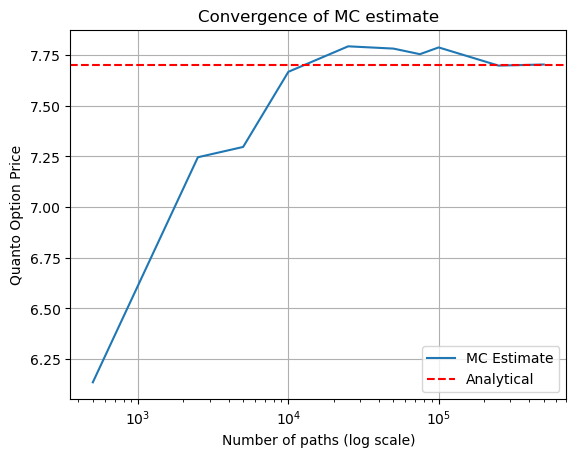

In [563]:
nPath_list = [500, 2500, 5000, 10000, 25000, 50000, 75000, 100000, 250000, 500000]
# Initialize list to store results for each nPath_list simulation
mcprice = []
# mcerror = []

for nPath in nPath_list:
    mc = quantoCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath)
    mcprice.append(mc)
    # mcerror.append(stderr)
    
# Plot
plt.plot(nPath_list,mcprice, label = "MC Estimate")
plt.axhline(y=analy, color='red', linestyle='--',label="Analytical")
plt.xlabel("Number of paths (log scale)")
plt.xscale("log")
plt.ylabel("Quanto Option Price")
plt.title("Convergence of MC estimate")
plt.legend()
plt.grid(True)

# plt.figure()
# plt.plot(nPath_list,mcerror)
# plt.xlabel("Number of paths (log scale)")
# plt.xscale("log")
# plt.ylabel("MC Standard Error")
# plt.title("MC Standard Error")
# plt.grid(True)

#### Part 3.

Let us also implement a Monte-Carlo pricer that prices quanto arithmetic Asian call option.
A quanto arithmetic Asian call option pays the option holder $F_0 \times \max(A - K, 0)$ on the settlement date $t_s$ in the quanto currency, where

\begin{align}
A = \frac{1}{n}\sum_{i=1}^n S_a(t_i).
\end{align}

where $t_1 < t_2 < \ldots < t_n \leq t_s$. Equivalently, the payoff in the underlying's denominated currency is $F \times \max(A - K, 0) \times S_b(t_s)$, where $S_b$ is the value of one quanto currency in the unit of underlying's denominated currency.

Design the signature of the pricer, explain the main difference from the implementation in exercise 2.
Conduct test cases that demonstrate the correctness of the implementation (e.g., for degenerate case with only 1 fixing, the closed form solution exists and the price converges).


#### MC Simulation Formulation

The risk-neutral pricing formula still holds, i.e.:
$$
V(0,S_a,S_b) = \mathbb{E}^Q[F_0 e^{-r_d T} (A-K)^+ S_b(T)]
$$
where the payoff is now dependent on the path of the underlying stock price, $A = \frac{1}{n}\sum_{i=1}^n S_a(t_i)$.

#### Pricer Algorithm

Generate Cholesky decomposition matrix

for N simulation paths:  
&nbsp; for n fixing dates:  
&nbsp; &nbsp; Generate (2 x n) i.i.d Brownian Motions  
&nbsp; &nbsp; Generate (2 x n) correlated Brownian Motions  
&nbsp; &nbsp; Compute the underlying stock price at each fixing dates  
&nbsp; &nbsp; Generate quanto exchange rate $S_b$ at terminal timestep

&nbsp; Compute path-dependent price average A

&nbsp; Compute discounted payoff

Compute MC average


Our Monte Carlo pricer implementation is as below:

In [664]:
def quantoArthAsianCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath, nfixdates):
    delta_t = T / nfixdates
    # Compute lower triangular matrix L
    C = np.array([[1,rho],[rho,1]]) # Correlation matrix
    L = np.linalg.cholesky(C) # Cholesky decomposition

    rng = np.random.default_rng(10)
    sum_H = 0
    sum_H_sq = 0

    for _ in range(nPath):
        S_a = np.zeros(nfixdates+1) # n fixing dates, but n+1 time index
        S_a[0] = s_a0
        # Generate correlated standard normal random vector
        Z = rng.normal(size=(2,nfixdates))
        Zc = L @ Z # Multiply with Cholesky decomposed lower triangular matrix L
        for i in range(1,nfixdates+1):
            # Simulate prices for underlying stock S_a(t) at each fixing dates
            S_a[i] = S_a[i-1] * np.exp( (rd - ra - 0.5 * sigmaA**2)*delta_t + sigmaA * np.sqrt(delta_t) * Zc[0,i-1] )
        
        # Simulate quanto exchange rate at terminal time
        S_b = s_b0 * np.exp( (rd - rb - 0.5 * sigmaB**2)*T + sigmaB * np.sqrt(T) * Zc[1,-1] )

        # Compute arithmetic mean of stock price (sum of stock price from t1 to tn, excluding price at t0
        At = np.sum(S_a[1:nfixdates+1]) / nfixdates
        
        # Compute discounted payoff function H
        H = F0 * np.exp(-rd * T) * np.maximum( At - K, 0 ) * S_b
        sum_H += H
        # sum_H_sq += H**2
    
    # Compute MC estimate and standard error
    mc = sum_H / nPath
    # stderr = np.sqrt( ( (sum_H_sq / nPath) - (sum_H / nPath)**2 ) / nPath )

    return mc #, stderr

To evaluate the performance of our MC pricer for the quanto Arithmatic Asian call option, we could not compare against analytical solution as the closed-form solution for it does not exist. Instead, we take the limit as the number of fixing dates approaches 1, which should converge to the price of a quanto European Call Option.

In [666]:
nfixdates = 1
# MC estimate for quanto Arithmetic Call Option Price (degenerate case with 1 fixing date):
arthmc = quantoArthAsianCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath, nfixdates)
print(f"Analytical price of quanto European Call Option: {analy:.4f}")
print(f"MC Estimate of quanto Arithmetic European Call Option: {arthmc.item():.4f}")

Analytical price of quanto European Call Option: 7.7023
MC Estimate of quanto Arithmetic European Call Option: 7.7047


The MC estimate of the quanto Arithmetic European Call Option with 1 fixing date approximates the analytical price of a quanto European Call option, and hence our MC pricer for quanto Arithmetic Asian Call Option is acceptable.

Furthermore, we can see from the plot below that the MC estimate price converges to the analytical price of a vanilla quanto European Call option as number of fixing dates approaches 1.

Hence, the implementation is correct and behaves as expected.

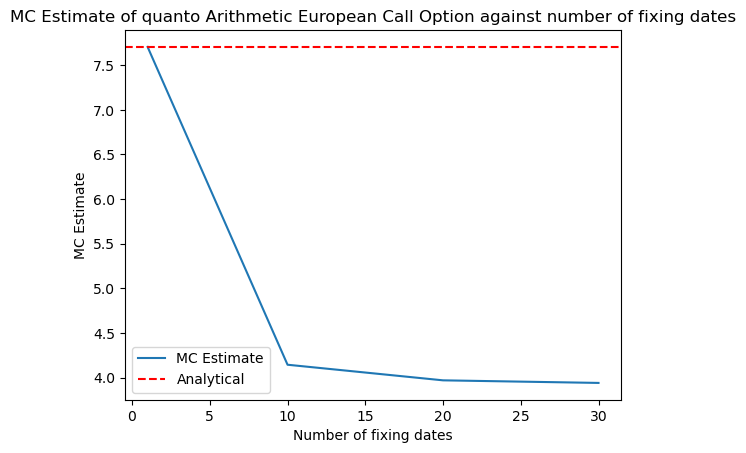

In [669]:
nfixdates_l = [1, 10, 20, 30]
arthmc_l = np.array([quantoArthAsianCallOptionMC(rd, ra, rb, sigmaA, sigmaB, rho, s_a0, s_b0, T, K, F0, nPath, nfixdates) \
                     for nfixdates in nfixdates_l])
plt.plot(nfixdates_l, arthmc_l,label="MC Estimate")
plt.xlabel("Number of fixing dates")
plt.ylabel("MC Estimate")
plt.title("MC Estimate of quanto Arithmetic European Call Option against number of fixing dates")
plt.axhline(y=analy, color='red', linestyle='--',label="Analytical")
plt.legend()



#### Difference between Part 2 and Part 3
The main difference between the implementation in Part 2 and Part 3 is that:
1. In Part 2, we only need to keep track of the state variable, $S_a, S_b$, at the initial and terminal timestep, and only need 1 simulation of the Brownian Motion.
2. In Part 3, we need to keep track of the state variable $S_a$ at each fixing dates, making it a path-dependent problem, requiring simulating number of Brownian Motions equal to the number of fixing dates for $S_a$, updating the state variable at each fixing dates as we progress through the algorithm. But only 1 simulation for $S_b$ as in Part 2.

#### State variable and step-wise induction formula for Part 3

The state variable used in the implementation above is $S_a$. Since $S_a$ has an explicit solution under Black-Scholes model, hence Euler discretization approximation scheme is not required here.

The step-wise induction formula can be derived as follows, for $t_2 > t_1$, we have that:

$$
\begin{split}
    X(t) &= S_a(t) \\
    dX(t) &= dS_a(t) = (r_d - r_a) S_a dt + \sigma_a S_a dW_a \\
    \int_0^{t_1} \frac{dS_a(t)}{S_a(t)} &= \int_0^{t_1} (r_d-r_a)dt + \sigma_a dW_a \\
    \Rightarrow S_a(t_1) &= S_a(0) e^{(r_d-r_a-\frac{\sigma_a^2}{2})t_1 + \sigma_a W_{t_1}} \\
    S_a(t_2) &= S_a(0) e^{(r_d-r_a-\frac{\sigma_a^2}{2})t_2 + \sigma_a W_{t_2}} \\
    \Rightarrow \frac{S_a(t_2)}{S_a(t_1)} &= e^{(r_d-r_a-\frac{\sigma_a^2}{2})(t_2-t_1) + \sigma_a (W_{t_2}-W_{t_1})} \\
    S_a(t_2) &= S_a(t_1) e^{(r_d-r_a-\frac{\sigma_a^2}{2})(t_2 - t_1) + \sigma_a (W_{t_2}-W_{t_1})}
\end{split}
$$

The step-wise induction formula of the state variable is thus
$$
S_a(t_{i+1}) = S_a(t_i) e^{(r_d-r_a-\frac{\sigma_a^2}{2})(\Delta t) + \sigma_a \Delta W_t}
$$
where $\Delta t = t_{i+1} - t_i$ and $\Delta W_t = W_{t_{i+1}} - W_{t_i}$.